## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [7]:
half = sym.Rational(1,2)

p = mf.ModelParameters.DynamicModel(2)
p.c = mf.ModelSymbol(value = 0.067,string = 'c') # mass per unit area (kg/m^2)
## Create some global parameters


p.m_1 = mf.ModelSymbol(value = 19.53,string = 'm_1') # mass per unit area (kg/m^2)
p.m_2 = mf.ModelSymbol(value = 19.53,string = 'm_2') # mass per unit area (kg/m^2)


p.s_1 = mf.ModelSymbol(value = 19.53,string = 's_1') # mass per unit area (kg/m^2)
p.s_2 = mf.ModelSymbol(value = 19.53,string = 's_2') # mass per unit area (kg/m^2)

# main Wing Structural Parameters
p.y_1 = sym.Symbol('y_1')
p.y_2 = sym.Symbol('y_2')

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho') # density
p.V = mf.ModelSymbol(value = 10,string = 'V') # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g') # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = -1.2,string = 'M_thetadot')

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0') # C_L of main wing

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point
#p.eta = mf.ModelMatrix(value = [1]*b_modes+[1]*t_modes+[1]*fwt_modes,symbols=sym.symbols(f'eta:{p.qs}'))# [1]*b_modes+[1e3]*t_modes#[p.EI**2]*b_modes+[p.GJ**2]*t_modes

#### Create Transforms

In [9]:
#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_x(p.q[0])
tip_frame = wing_root_frame.Translate(0,p.s_1,0).R_x(p.q[1])

#Create Elemnts
M_wing = ele.MassMatrix(p.m_1)
M_tip = ele.MassMatrix(p.m_2)

inner_wing_ele = ele.RigidElement(wing_root_frame.Translate(0,p.s_1/2,0),M_wing,gravityPotential=True)
tip_ele = ele.RigidElement(tip_frame.Translate(0,p.s_2/2,0),M_wing,gravityPotential=True)

# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_root_frame.Translate(0,p.y_1,0),p.a_0,(p.y_1,0,p.s_1),
                               alphadot = 0,
                               M_thetadot = p.M_thetadot,
                               e = 0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = 0,
                               alpha_zero = 0)

tip_AeroForces = ef.AeroForce.Generate(p,tip_frame.Translate(0,p.y_2,0),p.a_0,(p.y_2,0,p.s_2),
                               alphadot = 0,
                               M_thetadot = p.M_thetadot,
                               e = 0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = 0,
                               alpha_zero = 0)

CompositeForce = ef.CompositeForce(p,[wing_AeroForces,tip_AeroForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,tip_ele],CompositeForce)

In [31]:
sm.M*p.qdd

⎡⎛                        2⎞       ⎛       2                           2⎞    ⎤
⎢⎜m₁⋅s₁⋅s₂⋅cos(q₁)   m₁⋅s₂ ⎟       ⎜5⋅m₁⋅s₁                       m₁⋅s₂ ⎟    ⎥
⎢⎜──────────────── + ──────⎟⋅q₁̈ + ⎜──────── + m₁⋅s₁⋅s₂⋅cos(q₁) + ──────⎟⋅q₀̈⎥
⎢⎝       2             4   ⎠       ⎝   4                            4   ⎠    ⎥
⎢                                                                            ⎥
⎢                     2       ⎛                        2⎞                    ⎥
⎢                m₁⋅s₂ ⋅q₁̈   ⎜m₁⋅s₁⋅s₂⋅cos(q₁)   m₁⋅s₂ ⎟                    ⎥
⎢                ────────── + ⎜──────────────── + ──────⎟⋅q₀̈                ⎥
⎣                    4        ⎝       2             4   ⎠                    ⎦

In [27]:
p.fp.value = [0,0,0,0]
sm_lin = sm.linearise(p)
sm_lin.ExtForces.Q().jacobian(p.qd)
sm_lin.M

⎡       2                            2                           2⎤
⎢5⋅m₁⋅s₁                        m₁⋅s₂   m₁⋅s₁⋅s₂⋅cos(q̃₂)   m₁⋅s₂ ⎥
⎢──────── + m₁⋅s₁⋅s₂⋅cos(q̃₂) + ──────  ───────────────── + ──────⎥
⎢   4                             4             2             4   ⎥
⎢                                                                 ⎥
⎢                              2                       2          ⎥
⎢     m₁⋅s₁⋅s₂⋅cos(q̃₂)   m₁⋅s₂                   m₁⋅s₂           ⎥
⎢     ───────────────── + ──────                  ──────          ⎥
⎣             2             4                       4             ⎦

# Setup Numeric Model Parameters


In [70]:
tmax, dt = 5, 0.01

p.alpha_r.value = np.deg2rad(5)

ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

## create masses 

In [71]:
y0 = [0]*p.qs*2
sm_mini = sm.subs(p,p.GetSubs(0,y0))
def objectiveDeriv(t,y):
    deriv = sm_mini.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [72]:
np.round(np.array(sm_mini.M).astype(np.float64),2)# sym.nsimplify(sm_mini.M,tolerance=0.1)

array([[ 5.93818800e+04,  3.01857870e+05, -3.72354000e+03,
        -1.81708500e+04],
       [ 3.01857870e+05,  1.57828545e+06, -1.81708500e+04,
        -9.23685100e+04],
       [-3.72354000e+03, -1.81708500e+04,  9.67190000e+02,
         4.42487000e+03],
       [-1.81708500e+04, -9.23685100e+04,  4.42487000e+03,
         2.15933900e+04]])

In [73]:
# get the linearised sm
sm_lin = sm_mini.linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.eigenMatrices(p)

In [74]:
func = sym.lambdify((),(K,M),'numpy')

In [75]:
q = sym.Matrix(p.fp[::2])
qd = sym.Matrix(p.fp[1::2])
f = (sm_lin.f-sm_lin.ExtForces.Q())
f = (sm_lin.f-sm_lin.ExtForces.Q()).subs({p.x[i]:p.fp[i] for i in range(-1,-len(p.x)-1,-1)}).subs({i:0 for i in qd})

In [76]:
df = pd.DataFrame(columns=['v','aoa','q'])
vs = np.linspace(0,200,201)
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for v in vs:
    p.V.value = v 
    df = df.append({'aoa' : np.rad2deg(p.alpha_r(0,y0)), 'v' : v,'q':y0} , ignore_index=True)
data = df

In [77]:
flutdfv2 = pd.DataFrame() 
for i in range(0,len(data)):  
    # get the fixed point
    #lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]

    # get the jacobian evaluated at this point
    #j_lp = func(data['v'].iloc[i],np.deg2rad(data['Lambda'].iloc[i]),ratio,lp)
    # get eigen value information
    #jac_dat = dof2.ExtractEigenValueData(j_lp,sortby='Damping')
    p.V.value = data['v'].iloc[i]
    q = data['q'].iloc[i]
    q=[0]*p.qs*2
    evals, evecs = eig(*func())
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data   
    jac_dat['V'] = data['v'].iloc[i]
    #jac_dat['Mass Ratio'] = f'r = {ratio}'
    y = np.array(q)
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True) 

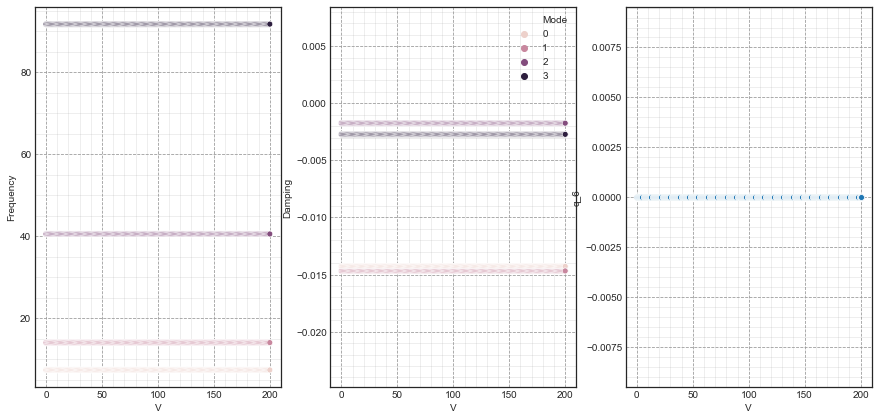

In [78]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
#data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2[flutdfv2['Lambda']==10]
#data = flutdfv2[flutdfv2['Stable']]
data = flutdfv2
fig, axes = plt.subplots(1,3,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],legend=False)
sns.scatterplot(data=data,x='V',y='Damping',hue='Mode',ax=axes[1])
sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',ax=axes[2])

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
#axes[0].set(ylim=(0,50))

In [61]:
flutdfv2[flutdfv2['Stable']]['V'].max()